In [0]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from numpy import sqrt, log1p
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns
from sklearn.base import BaseEstimator
from sys import modules

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', 10)

%matplotlib inline

This notebook includes a step-by-step For more details, see [Bike Sharing Demand][1] competition page on Kaggle.

[1]: https://www.kaggle.com/c/bike-sharing-demand "Bike Sharing Demand"

# Get the data

Upload *train.csv*.

> **Note:** Be careful not to confuse our internal *test_data*, which is splitted from Kaggle's *train.csv*, with the submission test data, which is given by Kaggle in a separate file called *test.csv*, and we will upload only at the very end of our work.

In [2]:
if 'google.colab' in modules:
    from google.colab import files
    uploaded = files.upload()
    

Saving train.csv to train (1).csv


**NOTE:** The file *test.csv* contains the data for the final submission, and we are not going to use it until the very end of this tutorial. We are going to create our own test data by splitting *train.csv*.

In [3]:
data = read_csv('train.csv', parse_dates=[0], index_col=0)
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


> **NOTE:** The data is sorted by the datetime index. Some manipulations along the way may shuffle the data, and we must be careful when that happens, because some of our conclusions are based on this sorting.

## Split the data

Using the generic *train_test_split()* is a reasonable option, but an even better one is to use the same logic as defined by the probelm statement itself (and the available data). Since the train and test data are divided by the days of the month (*train.csv* includes the beginning of the month and *test.csv* includes the end of the month), it make sense to keep this relation.

In [0]:
train_data = data.loc[data.index.day < 15]
test_data = data.loc[data.index.day >= 15]

## First impression

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8026 entries, 2011-01-01 00:00:00 to 2012-12-14 23:00:00
Data columns (total 11 columns):
season        8026 non-null int64
holiday       8026 non-null int64
workingday    8026 non-null int64
weather       8026 non-null int64
temp          8026 non-null float64
atemp         8026 non-null float64
humidity      8026 non-null int64
windspeed     8026 non-null float64
casual        8026 non-null int64
registered    8026 non-null int64
count         8026 non-null int64
dtypes: float64(3), int64(8)
memory usage: 752.4 KB


In [6]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,8026.0,2.505607,1.116640,1.00,2.0000,3.0000,4.0000,4.0000
holiday,8026.0,0.026788,0.161473,0.00,0.0000,0.0000,0.0000,1.0000
workingday,8026.0,0.686768,0.463837,0.00,0.0000,1.0000,1.0000,1.0000
weather,8026.0,1.411039,0.636480,1.00,1.0000,1.0000,2.0000,4.0000
temp,8026.0,20.088263,8.066977,0.82,13.9400,19.6800,27.0600,41.0000
atemp,8026.0,23.523856,8.761372,0.76,16.6650,23.4850,31.0600,45.4550
humidity,8026.0,61.660478,19.648239,0.00,46.0000,61.0000,78.0000,100.0000
windspeed,8026.0,12.703140,8.229619,0.00,7.0015,11.0014,16.9979,56.9969
casual,8026.0,35.340892,48.925630,0.00,4.0000,16.0000,48.0000,362.0000
registered,8026.0,154.40...,150.94...,0.00,35.0000,117.0000,221.0000,886.0000


For numeric-like features:

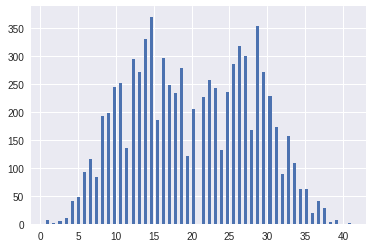

In [7]:
ax = train_data.temp.hist(bins=100)  
# temp / atemp / humidity / windspeed / registered / casual / count

For category-like features:

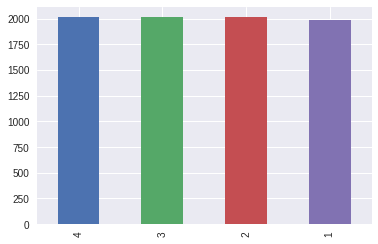

In [8]:
ax = train_data.season.value_counts().plot.bar()  
# season / holiday / workingday / weather

# Preprocessing - inspection and manipulation

## Time-related considerations

We are not dealing with time-series in our course, therefore the datetime should be exploded to its significant components. We add the *weekday* feature.

In [0]:
def explode_dt(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    # df['day'] = df.index.day  # This feels like an irrelevant info
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    return df

In [10]:
train_data = explode_dt(train_data)
train_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


**Thought:** Is the *year* important?

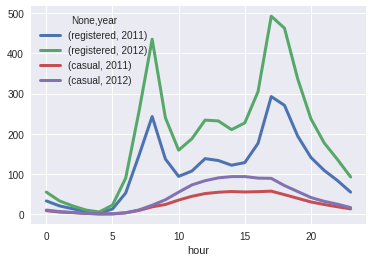

In [11]:
ax = train_data.groupby(['hour', 'year'])[['registered', 'casual']]\
    .mean().unstack().plot(lw=3)

**Conclusion:** There is a significant increase in the number of registered users in time. This is an important observation, but in this tutorial we will ignore this effect, and instead rely on the *year* data alone, which we will convert to 0's (for 2011) and 1's (for 2012).

In [0]:
train_data.year -= 2011

> An initial idea for how to look at the time-series data is illustrated below.

In [0]:
# import statsmodels.api as sm
# # Looking at rents of a specific day and hour 
# # (considering full weeks for the freq argument)
# rents = data.loc[(data.index.day<=14) & (data.index.hour==14), 'count']
# # Using the Wald decomposition algorithm
# decomposed = sm.tsa.seasonal_decompose(rents, model='additive',
#                                        freq=7, two_sided=False).plot()

## Continuous features

Only 4 columns represent "measurement" data.

In [0]:
meas_cols = ['temp', 'atemp', 'humidity', 'windspeed']

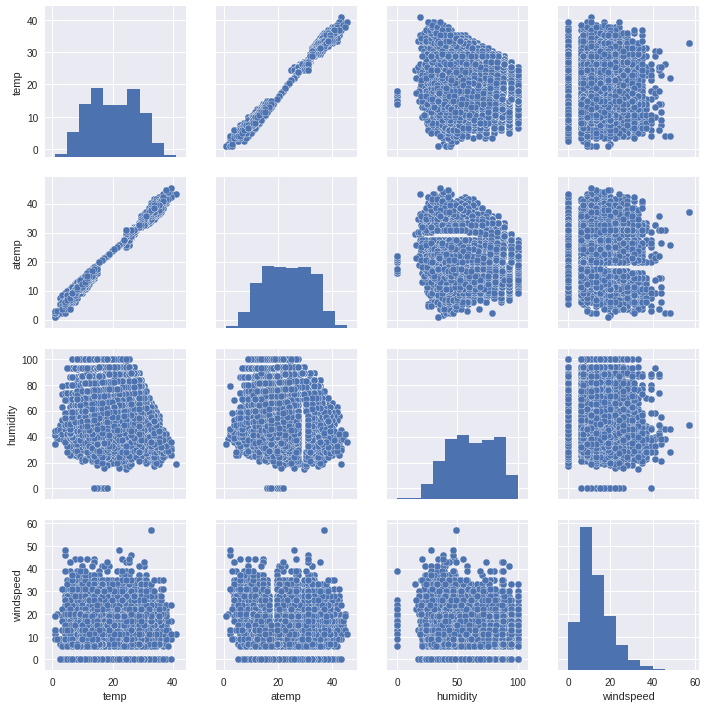

In [15]:
ax = sns.pairplot(train_data[meas_cols])

**Observations:**
* Missing values in windspeed
* Weird (linear?) relation between temp and atemp

### Missing values in *windspeed*

In [16]:
train_data.windspeed.value_counts().sort_index().head(10)

0.0000     1016
6.0032      650
7.0015      769
8.9981      838
11.0014     774
12.9980     732
15.0013     689
16.9979     578
19.0012     493
19.9995     384
Name: windspeed, dtype: int64

**Observations:** 
1. The windspeed data actually has integer values. There is nothing to do with this observation...
2. Values below 6 are missing. Next, we explore this further.

**Discussion: How should we impute the zeroes in *windspeed*?**

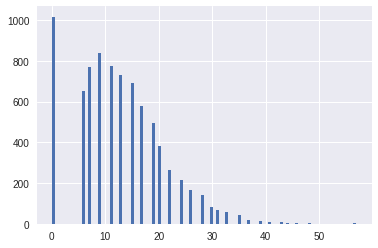

In [17]:
ax = train_data.windspeed.hist(bins=100)

There are 2 reasonable reasons for the (obviously problematic) 0's:
* **Meter error** - the meter is not sensitive enough, so anything below 6 m/h is truncated to 0. If this is the case, then it could be ignored, because it is reasonable to assume cyclists are not irritated by such a low wind.
* **System error** - we are concerned with the possibility that the missing values are at random due to some data collection problem (at the meter, at the communication, it doesn't really matter). In this case the 0's can actually stand for any value. If that's the case, then we should fix these values.

> **Note:** Another option is to drop records with 0 *windspeed*, but since it is a very common value, this is probably not a good idea.

**Thought:** The behaviour of the 0's over time would give us a hint about their nature.

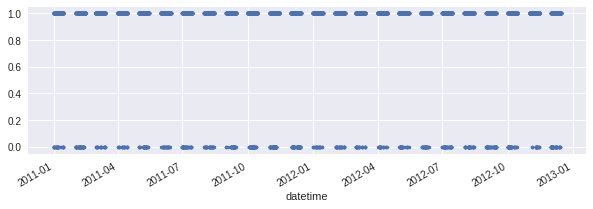

In [18]:
ax = (train_data.windspeed != 0).astype(int).plot(ls=' ', marker='.', figsize=(10, 3))  
# Try with (300, 3) for better visualization

**Conclusion:** It seems like the 0's in *windspeed* are **not systematic**, so it is still not clear what the reason for the missing values.

**Thought:** There are many ways for imputing the data. A reasonable imutation would be to impute each 0 with the mean of its neighbors in time. This can be done with [*rolling()*][rol].

[rol]: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html "rolling() API"

In [0]:
windspeed_smooth = train_data.windspeed.rolling(window=5, center=True).mean()

**Illustration:** Let's plot the original and the smoothed *windspeed* for a short period (otherwise the data is too dense).

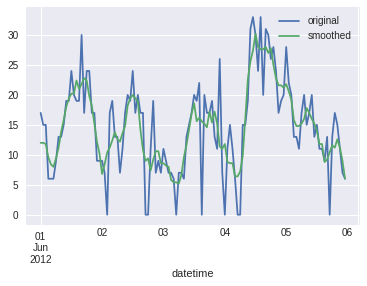

In [20]:
windspeed_compare = pd.DataFrame({'original': train_data.windspeed, 
                                  'smoothed': windspeed_smooth},
                                 index=train_data.index)
interval_inds = train_data.index.to_series()\
    .between('2012-06-01 00:00:00','2012-06-05 23:00:00')
ax = windspeed_compare.loc[interval_inds].plot()

This imputation looks reasonable, so we use it.

In [0]:
train_data.loc[:, 'windspeed'] = windspeed_smooth

**NOTE:** The rolling window has left 4 *NA*s in our data (2 at the beginning and 2 at the end). We will simply remove these records.

In [0]:
train_data = train_data[train_data.windspeed.notnull()]

> **NOTE:** A different, yet very powerful and common approach, is to impute using a regressor that learns from the non-missing data. A simple example using random forest regressor is given below. Note that by the nature of this specific regressor (random forest), if you remove the 0's from the training data, you are eliminating them from the imputation result.

In [0]:
# relevant_cols = ['season', 'weather', 'temp', 'humidity', 'hour', 'month']
# X_windspeed_gt0 = train_data.loc[train_data.windspeed>0, relevant_cols]
# y_windspeed_gt0 = train_data.windspeed.loc[train_data.windspeed>0]

# imputer_rf = RandomForestRegressor(random_state=1234).\
#     fit(X_windspeed_gt0, y_windspeed_gt0)

# windspeed_ = imputer_rf.predict(train_data[relevant_cols])

> **NOTE:** The regressor not only imputed the "missing data", but also modified the non-missing data. We can change the entire *windspeed* data or we can impute only the "missing values".

### temp

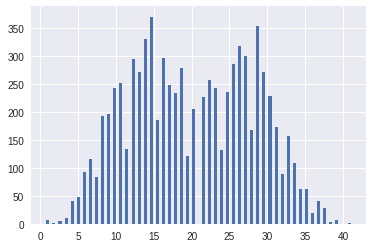

In [24]:
train_data.temp.hist(bins=100)

**Observation:** It is interesting to see the non-standard distribution, which means long winter and summer but shorter fall and spring.

**Conclusion:** We will drop *season*.

In [0]:
train_data.drop('season', axis=1, inplace=True)

In [26]:
train_data.head(5)

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday
datetime,,,,,,,,,,,,,,
2011-01-01 02:00:00,0,0,1,9.02,13.635,80,0.00000,5,27,32,0,1,2,5
2011-01-01 03:00:00,0,0,1,9.84,14.395,75,1.20064,3,10,13,0,1,3,5
2011-01-01 04:00:00,0,0,1,9.84,14.395,75,1.20064,0,1,1,0,1,4,5
2011-01-01 05:00:00,0,0,2,9.84,12.880,75,1.20064,0,1,1,0,1,5,5
2011-01-01 06:00:00,0,0,1,9.02,13.635,80,1.20064,2,0,2,0,1,6,5


> **Note:** Due to the train-test split we don't see the entire data, and possibly miss some phenomena. An example to that is a bunch of outliers in *atemp* on Aug 17th, 2012. I give here an example of processing them, in case someone wants to use a different splitting approach.

In [0]:
# # Visualize the outliers
# ax = train_data.plot.scatter(x='temp', y='atemp')
# # Zoom-in on the outliers and inspect them
# train_data[(train_data.temp>20) & (train_data.atemp<20)].head()
# # Removing the outliers
# train_data = train_data[~((train_data.temp>20) & (train_data.atemp<20))]

### Weird relation between temp and atemp

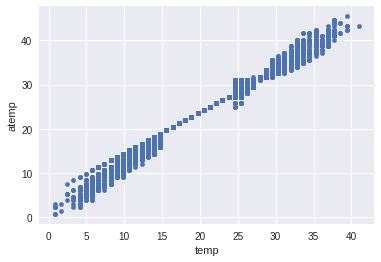

In [28]:
ax = train_data.plot.scatter(x='temp', y='atemp')

**Thoughts:** It is clear that *atemp* is very similar to *temp*, but it looks rather weird... We will drop this feature...

In [0]:
train_data.drop('atemp', axis=1, inplace=True)

> **Note:** This means that our previous outlier detection was unnecessary...

### Humidity

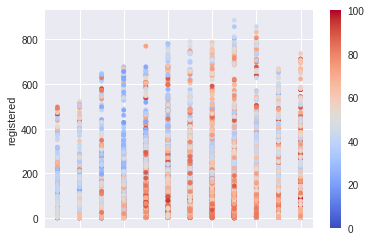

In [30]:
ax = train_data.plot.scatter(x='month', y='registered', 
                             c=train_data.humidity, cmap='coolwarm', s=20)

**Conclusion:** The humidity has very low influence for registered, but significant influence for casual cyclists (you need to change the *y* argument above in order to see that). We will keep this feature as it is.

## Special days

### *workingday* and *holiday*

In [31]:
train_data.groupby(['workingday', 'holiday', 'weekday'])\
    ['registered', 'casual'].median()

registered  casual
workingday holiday weekday                    
0          0       5            106.5     28.0
                   6             89.0     24.0
           1       0            123.0     31.0
                   2            239.5    149.0
                   4            133.0     12.5
1          0       0            116.0     13.0
                   1            119.5     12.0
                   2            119.0     11.0
                   3            133.0     12.0
                   4            137.5     16.0

**Conclusion**: The days are workingday / weekends / holiday. In the US there are no religious holidays, so they are mutually exclusive.

**Alert:** What is going on with holidays on Monday?

In [32]:
holy_mondays_ind = (train_data.workingday==0) & (train_data.weekday==2)
train_data.loc[holy_mondays_ind, 'casual'].head()

datetime
2012-07-04 00:00:00    19
2012-07-04 01:00:00    27
2012-07-04 02:00:00    27
2012-07-04 03:00:00     9
2012-07-04 04:00:00     5
Name: casual, dtype: int64

**Conclusion:** This data is made of outliers due to 4th of July (USA independence day), so we remove it from the **training** data.

In [0]:
july4th_ind = train_data.index.to_series()\
    .between('2012-07-04 00:00:00','2012-07-04 23:00:00')
train_data = train_data.loc[~july4th_ind]

**Thought:** Should we separate holiday & weekend? We will assume NOT for this analysis, so we drop *holiday*.

In [0]:
train_data.drop('holiday', axis=1, inplace=True)

### Working days

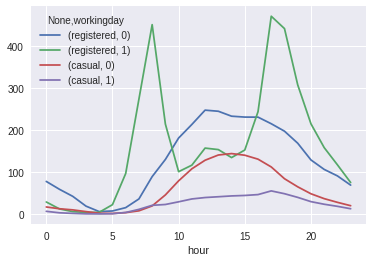

In [35]:
ax = train_data.groupby(['workingday', 'hour'])[['registered', 'casual']]\
    .mean().unstack(0).plot()

> **NOTE:** It is very important to notice the impact of *weekday* on the registered users. Compare the plot above with the one below, which does not groupby *weekday* (code below).

In [0]:
# ax = train_data.groupby('hour')[['registered', 'casual']]\
#     .mean().plot()

**Observation:** Registered and casual users behave very differently in terms of workingday and hour. On working days, registered users rent bike in the rush hours (getting to and from work), but less during working hours, while on weekends everyone is biking during the day.

Let's see the impact of *weekday*.

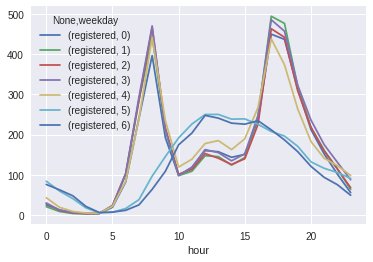

In [37]:
ax = train_data.groupby(['weekday', 'hour'])[['registered']]\
    .mean().unstack(0).plot()

**Thought:** It looks like the actual weekday is not very important, besides the question whether it is a weekend or not. Since this information is already captured by the workingday columns, we decide to drop the weekday column.

In [0]:
train_data.drop('weekday', axis=1, inplace=True)

**<font color=red>Important Conclusion:</font>** We should make 4 different models for workingday/non-workingday and for registered/casual. We also note that some features should be dealt differently for different models (at least *hour*).

> **NOTE:** *weekday* does have some influence on the casuals, so perhaps it is better to drop this data only for the registered users. We will ignore this option in this tutorial and drop *weekday* for all models.

## Categorical features

The features *weather*, *month* and *hour* are basically categorical, and their processing depends on the chosen model.

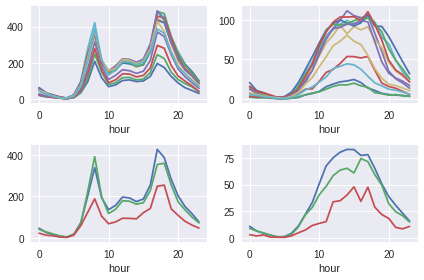

In [39]:
fig, axes = plt.subplots(2, 2, tight_layout=True);
train_data.groupby(['hour', 'month'])['registered']\
    .mean().unstack().plot(ax=axes[0][0], legend=None)
train_data.groupby(['hour', 'weather'])['registered']\
    .mean().unstack().plot(ax=axes[1][0], legend=None)
train_data.groupby(['hour', 'month'])['casual']\
    .mean().unstack().plot(ax=axes[0][1], legend=None)
train_data.groupby(['hour', 'weather'])['casual']\
    .mean().unstack().plot(ax=axes[1][1], legend=None)

**Alert:** The *weather* data should have 4 lines, but has only 3...

In [40]:
train_data.weather.value_counts()

1    5353
2    1993
3     651
4       1
Name: weather, dtype: int64

**Thought:** weather 4 is very rare, so we replace it with 3...

> **NOTE:** This is another example where the train data may miss potential values in the data. This may cause problems when applying the model to test data, which includes such values.

In [0]:
train_data.loc[train_data.weather==4, 'weather'] = 3

In [42]:
train_data.head()

,workingday,weather,temp,humidity,windspeed,casual,registered,count,year,month,hour
datetime,,,,,,,,,,,
2011-01-01 02:00:00,0,1,9.02,80,0.00000,5,27,32,0,1,2
2011-01-01 03:00:00,0,1,9.84,75,1.20064,3,10,13,0,1,3
2011-01-01 04:00:00,0,1,9.84,75,1.20064,0,1,1,0,1,4
2011-01-01 05:00:00,0,2,9.84,75,1.20064,0,1,1,0,1,5
2011-01-01 06:00:00,0,1,9.02,80,1.20064,2,0,2,0,1,6


# The 4 models

We are going to build 4 random forest regressors.

> **NOTE:** We will not train-test our 4 sub-models, but rely on cross-validation alone.

**Alert:** In this tutorial I am constructing only a single model, and then assume it applies to all 4 datasets. I know this is wrong, but I don't have time for that.

## Evaluation

This competition is evaluated using the [RMSLE][rmsle] score. Since this score is not available in [Scikit-Learn built-in scorers][sks], we create it by ourselves using the [make_scorer()][ms] function.

[rmsle]: https://www.slideshare.net/KhorSoonHin/rmsle-cost-function "RMSLE explained"
[sks]: http://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules "Scikit-Learn scorers"
[ms]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html "make_scorer() API"

In [0]:
def rmsle(y, y_pred):
    return sqrt(MSE(log1p(pd.Series(y_pred).clip_lower(0)), log1p(y)))

In [0]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## Model \#1 (*rw*) - Registered users on Working days

In [0]:
train_data_rw = train_data.loc[train_data.workingday==1]\
    .drop(['count', 'casual', 'workingday'], axis=1, inplace=False)

In [46]:
train_data_rw.head()

,weather,temp,humidity,windspeed,registered,year,month,hour
datetime,,,,,,,,
2011-01-03 00:00:00,1,9.02,44,21.80046,5,0,1,0
2011-01-03 01:00:00,1,8.20,44,21.60080,2,0,1,1
2011-01-03 04:00:00,1,6.56,47,24.60106,1,0,1,4
2011-01-03 05:00:00,1,6.56,47,22.40078,3,0,1,5
2011-01-03 06:00:00,1,5.74,50,20.60116,30,0,1,6


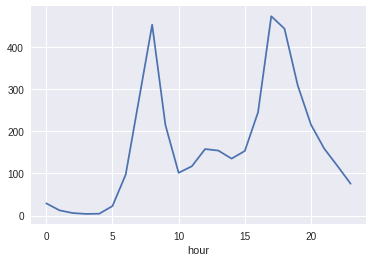

In [47]:
ax = train_data_rw.groupby('hour')['registered'].mean().plot(legend=None)

### Feature Engineering

#### *month* & *hour*

When applying trees it is very important to reduce the number of features, so it is better *NOT* to use dummy variables. Hence, we decide to keep *hour* and *month* numerical, hoping that the tree will join together natural sequences of months (e.g. March to May) and hours (e.g. 11-14).

> **Note:** An alternative approach would be to use many dummy variables, but then the number of feature increases, and other models would be more suitable (e.g. linear models & k-NN). An examplary code for this engineering is given below.

In [0]:
# def bin_hour(df):
#     df['hour'] = pd.cut(df.hour, bins=[0, 6, 9, 16, 19, 23], include_lowest=True, 
#                      labels=['midnight', 'morning rush', 'work', 'evening rush', 'evening'],)
#     return df 

# train_data_rw = pd.get_dummies(bin_hour(train_data_rw))

#### *weather*

*weather* has only 3 categories, and we can trust the model to separate them easily.

### Modelling

In [0]:
X_rw = train_data_rw.drop('registered', axis=1, inplace=False)
y_rw = train_data_rw['registered']

In [108]:
X_rw.columns

Index(['weather', 'temp', 'humidity', 'windspeed', 'year', 'month', 'hour'], dtype='object')

In [0]:
rw_model_rf = RandomForestRegressor(n_estimators=200,
                                    max_features='auto', random_state=0)

**NOTE:** Random forests shine when their trees are over-fitted, so we will keep the over-fitting hyper-parameters of the internal trees (*max_depth*, *min_samples_split*, etc.). A very nice explanation of tuning this model can be found in [this artical by Analytics Vidhya][trf].

[trf]: https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/ "Tuning RandomForestRegressor)"

In [0]:
scores = cross_val_score(estimator=rw_model_rf, X=X_rw, y=y_rw, 
                         cv=5, scoring=rmsle_scorer)

In [115]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.468
The standard deviation is 0.177


This looks like a promising model, so let's keep it :-)

In [53]:
rw_model_rf.fit(X=X_rw, y=y_rw)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

### Dimensionality reduction

Let's try to see if we can improve our model by removing unnecessary features. The problem at the moment is that *hour* is so important that it "shadows" the true relevancy of the other features. We can try to fit a model **without** *hour* and see if the importances change.

In [54]:
X_rw_no_hour = train_data_rw.drop(['registered', 'hour'], axis=1, inplace=False)
y_rw_no_hour = train_data_rw['registered']
rw_model_rf_no_hour = RandomForestRegressor(n_estimators=100, 
                                            max_features='auto', random_state=0)
rw_model_rf_no_hour.fit(X=X_rw_no_hour, y=y_rw_no_hour)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [55]:
imps_rw = pd.Series(rw_model_rf.feature_importances_, 
                    index=X_rw.columns, name='with hour')
imps_rw_no_hour = pd.Series(rw_model_rf_no_hour.feature_importances_, 
                            index=X_rw_no_hour.columns, name='without hour')
pd.concat([imps_rw, imps_rw_no_hour], axis=1).sort_values(by='without hour', ascending=False)

,with hour,without hour
windspeed,0.011962,0.330512
humidity,0.026264,0.231183
temp,0.040237,0.211095
month,0.073596,0.108927
year,0.096209,0.071973
weather,0.017330,0.046310
hour,0.734402,NaN


**Conclusion:** It seems like we could maybe drop the *weather* and *year* data.

In [56]:
X_rw_reduced = train_data_rw.drop(['registered', 'weather', 'year'], 
                                  axis=1, inplace=False)
y_rw_reduced = train_data_rw['registered']
rw_model_rf_reduced = RandomForestRegressor(n_estimators=100, random_state=0)
rw_model_rf_reduced.fit(X=X_rw_reduced, y=y_rw_reduced)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
scores = cross_val_score(estimator=rw_model_rf_reduced, 
                         X=X_rw_reduced, y=y_rw_reduced, 
                         cv=10, scoring=rmsle_scorer)

In [58]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.582
The standard deviation is 0.118


Well, we tried...

## Hyper-parameter optimization

In [0]:
param_grid = [{'max_features': ['auto', 3, 5, 7], 'bootstrap': [True], 'oob_score': [True, False]},
              {'max_features': ['auto', 3, 5, 7], 'bootstrap': [False], 'oob_score': [False]}]

In [0]:
rw_model_rf_gs = GridSearchCV(rw_model_rf, param_grid=param_grid, scoring=rmsle_scorer, cv=5)

In [61]:
rw_model_rf_gs.fit(X_rw, y_rw)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [3, 5, 7], 'bootstrap': [True], 'oob_score': [True, False]}, {'max_features': [3, 5, 7], 'bootstrap': [False], 'oob_score': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

In [0]:
best_params = rw_model_rf_gs.best_params_

In [0]:
scores = cross_val_score(estimator=rw_model_rf_gs.best_estimator_, 
                         X=X_rw, y=y_rw, cv=10, scoring=rmsle_scorer)

In [64]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.382
The standard deviation is 0.0745


**And finally:**

In [0]:
rw_model_rf = rw_model_rf_gs.best_estimator_.fit(X_rw, y_rw)

## Model \#2 (*rn*) - Registered users on Non-working days

In [0]:
train_data_rn = train_data.loc[train_data.workingday==0]\
    .drop(['count', 'casual', 'workingday'], axis=1, inplace=False)

In [67]:
train_data_rn.head()

,weather,temp,humidity,windspeed,registered,year,month,hour
datetime,,,,,,,,
2011-01-01 02:00:00,1,9.02,80,0.00000,27,0,1,2
2011-01-01 03:00:00,1,9.84,75,1.20064,10,0,1,3
2011-01-01 04:00:00,1,9.84,75,1.20064,1,0,1,4
2011-01-01 05:00:00,2,9.84,75,1.20064,1,0,1,5
2011-01-01 06:00:00,1,9.02,80,1.20064,0,0,1,6


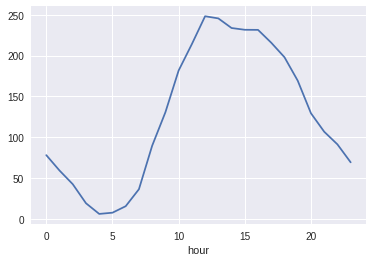

In [68]:
ax = train_data_rn.groupby('hour')['registered'].mean().plot(legend=None)

In [0]:
X_rn = train_data_rn.drop('registered', axis=1, inplace=False)
y_rn = train_data_rn['registered']

In [0]:
rn_model_rf = RandomForestRegressor(n_estimators=100, random_state=0, **best_params)

In [0]:
scores = cross_val_score(estimator=rn_model_rf, 
                         X=X_rn, y=y_rn, cv=10, scoring=rmsle_scorer)

In [72]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.465
The standard deviation is 0.172


## Model \#3 (*cw*) - Casual users on Working days

In [0]:
train_data_cw = train_data.loc[train_data.workingday==1]\
    .drop(['count', 'registered', 'workingday'], axis=1, inplace=False)

In [74]:
train_data_cw.head()

,weather,temp,humidity,windspeed,casual,year,month,hour
datetime,,,,,,,,
2011-01-03 00:00:00,1,9.02,44,21.80046,0,0,1,0
2011-01-03 01:00:00,1,8.20,44,21.60080,0,0,1,1
2011-01-03 04:00:00,1,6.56,47,24.60106,0,0,1,4
2011-01-03 05:00:00,1,6.56,47,22.40078,0,0,1,5
2011-01-03 06:00:00,1,5.74,50,20.60116,0,0,1,6


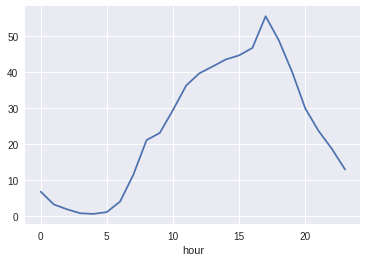

In [75]:
ax = train_data_cw.groupby('hour')['casual'].mean().plot(legend=None)

In [0]:
X_cw = train_data_cw.drop('casual', axis=1, inplace=False)
y_cw = train_data_cw['casual']

In [0]:
cw_model_rf = RandomForestRegressor(n_estimators=100, random_state=0, **best_params)

In [0]:
scores = cross_val_score(estimator=cw_model_rf, 
                         X=X_cw, y=y_cw, cv=10, scoring=rmsle_scorer)

In [79]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.677
The standard deviation is 0.166


## Model \#4 (*cn*) - Casual users on Non-working days

In [0]:
train_data_cn = train_data.loc[train_data.workingday==0]\
    .drop(['count', 'registered', 'workingday'], axis=1, inplace=False)

In [81]:
train_data_cn.head()

,weather,temp,humidity,windspeed,casual,year,month,hour
datetime,,,,,,,,
2011-01-01 02:00:00,1,9.02,80,0.00000,5,0,1,2
2011-01-01 03:00:00,1,9.84,75,1.20064,3,0,1,3
2011-01-01 04:00:00,1,9.84,75,1.20064,0,0,1,4
2011-01-01 05:00:00,2,9.84,75,1.20064,0,0,1,5
2011-01-01 06:00:00,1,9.02,80,1.20064,2,0,1,6


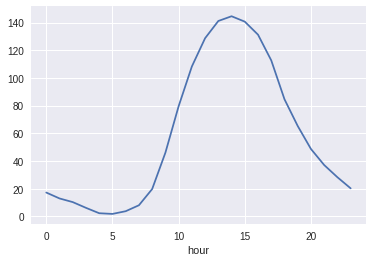

In [82]:
ax = train_data_cn.groupby('hour')['casual'].mean().plot(legend=None)

In [0]:
X_cn = train_data_cn.drop('casual', axis=1, inplace=False)
y_cn = train_data_cn['casual']

In [0]:
cn_model_rf = RandomForestRegressor(n_estimators=100, random_state=0, **best_params)

In [0]:
scores = cross_val_score(estimator=cn_model_rf, 
                         X=X_cn, y=y_cn, cv=10, scoring=rmsle_scorer)

In [86]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.673
The standard deviation is 0.219


# The final (additive) model

Very often you have to construct your own Estimator, and [this article by Daniel Hnyk][myoe] is probably the best introduction for how to do it properly.

[myoe]: http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/ "Creating your own estimator in scikit-learn by Daniel Hnyk"

In [0]:
class ModelCombiner(BaseEstimator):
    def __init__(self, estimators):
        """estimators is a dictionary of estimators corresponding 
        to the keys {'RW', 'RN', 'CW', 'CN'}
        """
        self.estimators = estimators
        
    def fit(self, X, y=None):   
        """Here X includes 'count', registered' and 'casual'
        """
        # Model RW
        X_w = X.loc[X.workingday==1]\
            .drop(['count', 'casual', 'registered', 'workingday'], 
                  axis=1, inplace=False)
        y_rw = X.loc[X.workingday==1, 'registered']
        self.estimators['RW'].fit(X_w, y_rw)
        # Model CW
        X_w = X.loc[X.workingday==1]\
            .drop(['count', 'casual', 'registered', 'workingday'], 
                  axis=1, inplace=False)
        y_cw = X.loc[X.workingday==1, 'casual']
        self.estimators['CW'].fit(X_w, y_cw)        
        # Model RN
        X_n = X.loc[X.workingday==0]\
            .drop(['count', 'casual', 'registered', 'workingday'], 
                  axis=1, inplace=False)
        y_rn = X.loc[X.workingday==0, 'registered']
        self.estimators['RN'].fit(X_n, y_rn)        
        # Model CN
        X_n = X.loc[X.workingday==0]\
            .drop(['count', 'casual', 'registered', 'workingday'], 
                  axis=1, inplace=False)
        y_cn = X.loc[X.workingday==0, 'casual']
        self.estimators['CN'].fit(X_n, y_cn)
        
        return self
    
    def predict(self, X, y=None):
        """Here X does NOT include 'count', 'registered' and 'casual'
        """
        X_w = X.loc[X.workingday==1].drop(['workingday'], axis=1, inplace=False)
        X_n = X.loc[X.workingday==0].drop(['workingday'], axis=1, inplace=False)
        
        # Model RW
        y_rw_ = pd.Series(self.estimators['RW'].predict(X_w), 
                          index=X_w.index, name='RW')
        # Model RN
        y_rn_ = pd.Series(self.estimators['RN'].predict(X_n), 
                          index=X_n.index, name='RN')
        y_r_ = pd.concat([y_rw_, y_rn_], axis=0)
        
        # Model CW
        y_cw_ = pd.Series(self.estimators['CW'].predict(X_w), 
                          index=X_w.index, name='CW')
        # Model CN
        y_cn_ = pd.Series(self.estimators['CN'].predict(X_n), 
                          index=X_n.index, name='CN')
        y_c_ = pd.concat([y_cw_, y_cn_], axis=0)
        
        return y_r_ + y_c_

In [0]:
all4_model = ModelCombiner({'RW': rw_model_rf, 'RN': rn_model_rf, 
                            'CW': cw_model_rf, 'CN': cn_model_rf})

In [89]:
all4_model.fit(train_data)

ModelCombiner(estimators={'RW': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estim...n_estimators=100, n_jobs=1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)})

In [0]:
y_pred_train = all4_model\
    .predict(train_data.drop(['count', 'casual', 'registered'], 
                             axis=1, inplace=False))

In [91]:
y_pred_train.sort_index().head()

datetime
2011-01-01 02:00:00    27.57
2011-01-01 03:00:00    14.29
2011-01-01 04:00:00     2.14
2011-01-01 05:00:00     2.04
2011-01-01 06:00:00     2.30
dtype: float64

In [92]:
rmsle(y=train_data['count'].sort_index(), y_pred=y_pred_train.sort_index())

0.153635006027249

# Validation

We now turn to our test data...

In [0]:
data = test_data
data = explode_dt(data)
data.year -= 2011
train_data.loc[:, 'windspeed'] = \
    train_data.windspeed.rolling(window=5, center=True).mean()
train_data = train_data[train_data.windspeed.notnull()]
data.drop('season', axis=1, inplace=True)
data.drop('atemp', axis=1, inplace=True)
data.drop('holiday', axis=1, inplace=True)
data.drop('weekday', axis=1, inplace=True)

data.loc[data.weather==4, 'weather'] = 3

In [0]:
y_pred_test = all4_model\
    .predict(data.drop(['count', 'casual', 'registered'], 
                       axis=1, inplace=False))

In [95]:
rmsle(y=test_data['count'].sort_index(), y_pred=y_pred_test.sort_index())

0.36091280213566707

**Alert:** This result obviously means over-fitting...

# Submission

In [116]:
if 'google.colab' in modules:
    from google.colab import files
    uploaded = files.upload()

Saving test.csv to test (1).csv


In [0]:
data = read_csv('test.csv', parse_dates=[0], index_col=0)
data = explode_dt(data)
data.year -= 2011
train_data.loc[:, 'windspeed'] = \
    train_data.windspeed.rolling(window=5, center=True).mean()
train_data = train_data[train_data.windspeed.notnull()]
data.drop('season', axis=1, inplace=True)
data.drop('atemp', axis=1, inplace=True)
data.drop('holiday', axis=1, inplace=True)
data.drop('weekday', axis=1, inplace=True)

data.loc[data.weather==4, 'weather'] = 3

In [118]:
y_pred_submission = all4_model.predict(data).rename('count')
y_pred_submission.head()

datetime
2011-01-20 00:00:00    8.68
2011-01-20 01:00:00    5.10
2011-01-20 02:00:00    3.57
2011-01-20 03:00:00    2.92
2011-01-20 04:00:00    2.49
Name: count, dtype: float64

In [0]:
y_pred_submission.to_csv('submission.csv', header=True)

In [0]:
if 'google.colab' in modules:
    files.download('submission.csv')